### Logistic Regression Credit Risk

Dataset generado de forma aleatoria para efectos educativos.

### Datos de contacto

- Correo electronico: ortizmontilla@gmail.com


In [ ]:
''' 
pip install xgboost scikit-learn
pip install graphviz xgboost
pip install openpyxl
'''

In [1]:
pwd

'/Users/michael/Documents/Python/ProyestosPersonales/Modelos/statistical_models/xgboots/01 - Credit_risk_model/NOTEBOOKS'

In [2]:
# Tratamiento de datos
import pandas as pd
import numpy as np

# Modeling
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, auc

# Gráficos
import matplotlib.pyplot as plt

In [3]:
# Guardar el conjunto de datos transformado en un nuevo archivo parquet
data = pd.read_parquet('/Users/michael/Documents/Python/ProyestosPersonales/Modelos/statistical_models/xgboots/01 - Credit_risk_model/DATA/dataset_crediticio_Logict_woe.parquet')
data.head(3)

resultado_del_riesgo  periodo  edad_WOE  historial_crediticio_WOE  \
0                     1  2022-06      0.99                      1.00   
1                     1  2022-05      1.32                      1.03   
2                     1  2022-04      1.12                      0.97   

   plazo_del_prestamo_WOE  tasa_de_interes_WOE  numero_de_dependientes_WOE  \
0                    1.28                 1.19                        1.13   
1                    0.93                 0.72                        1.06   
2                    1.03                 1.70                        0.98   

   estado_laboral_WOE  proposito_del_prestamo_WOE  estado_civil_WOE  \
0                 1.0                        1.11              1.05   
1                 1.0                        1.07              1.05   
2                 1.0                        0.96              0.96   

   nivel_de_educacion_WOE  
0                    0.97  
1                    0.97  
2                    1.01

### Logistic Regression

In [4]:
# Dividir los datos en conjunto de entrenamiento y prueba
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)
print(train_data.shape)
print(test_data.shape)

(8000, 11)
(2000, 11)


In [5]:
# Tasa de malos conjunto de entrenamaiento
bad_rate_dev = train_data['resultado_del_riesgo'].value_counts().reset_index()
bad_rate_dev = bad_rate_dev.rename(columns={'index': 'Categorias', 'resultado_del_riesgo': 'Qtd'})
bad_rate_dev['%'] = round(bad_rate_dev['Qtd'] / bad_rate_dev['Qtd'].sum(), 1) * 100
bad_rate_dev

Categorias   Qtd     %
0           1  7103  90.0
1           0   897  10.0

In [6]:
# Tasa de malos conjunto de validación
bad_rate_val = test_data['resultado_del_riesgo'].value_counts().reset_index()
bad_rate_val = bad_rate_val.rename(columns={'index': 'Categorias', 'resultado_del_riesgo': 'Qtd'})
bad_rate_val['%'] = round(bad_rate_val['Qtd'] / bad_rate_val['Qtd'].sum(), 1) * 100
bad_rate_val

Categorias   Qtd     %
0           1  1789  90.0
1           0   211  10.0

In [7]:
# Definir las columnas predictoras (características) y la variable objetivo
features = ['edad_WOE','historial_crediticio_WOE','plazo_del_prestamo_WOE','tasa_de_interes_WOE',
'numero_de_dependientes_WOE','estado_laboral_WOE','proposito_del_prestamo_WOE','estado_civil_WOE',
'nivel_de_educacion_WOE']
target = 'resultado_del_riesgo'

In [8]:
# Crear el modelo de regresión logística
model = LogisticRegression()

# Entrenar el modelo en el conjunto de entrenamiento
model.fit(train_data[features], train_data[target])

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [9]:
# Evaluar el modelo en el conjunto de prueba
probabilities = model.predict_proba(test_data[features])[:, 1]
roc_auc = roc_auc_score(test_data[target], probabilities)

In [10]:
# Calcular las métricas de KS y Gini
fpr, tpr, _ = roc_curve(test_data[target], probabilities)
ks = max(tpr - fpr)
gini = 2 * roc_auc - 1

In [11]:
# Imprimir métricas
print("AUC-ROC:", roc_auc)
print("KS:", ks)
print("Gini:", gini)

AUC-ROC: 0.6037157033901224
KS: 0.167307320407228
Gini: 0.20743140678024474


In [12]:
# Calcular el score para cada cliente
train_data['score'] = np.round(model.predict_proba(train_data[features])[:, 1]*1000)

### Tabla resumen distribuciones

In [13]:
# Dividir los datos en deciles naturales según el 'score'
train_data['decil'] = pd.qcut(train_data['score'], q=10, labels=False)

In [14]:
# Calcular las métricas por decil
summary_table = train_data.groupby('decil').agg({
    'score': ['min', 'max'],
    'resultado_del_riesgo': ['sum', lambda x: len(x) - sum(x)],
})
summary_table.head()

score        resultado_del_riesgo           
         min    max                  sum <lambda_0>
decil                                              
0      697.0  829.0                  645        175
1      830.0  850.0                  654        127
2      851.0  866.0                  704        107
3      867.0  879.0                  691        100
4      880.0  891.0                  715         89

In [15]:
# Renombrar columnas
summary_table.columns = ['Min Probabilidad', 'Max Probabilidad', 'Eventos', 'No Eventos']
summary_table.head()

Min Probabilidad  Max Probabilidad  Eventos  No Eventos
decil                                                         
0                 697.0             829.0      645         175
1                 830.0             850.0      654         127
2                 851.0             866.0      704         107
3                 867.0             879.0      691         100
4                 880.0             891.0      715          89

In [16]:
summary_table['No Eventos'].sum()

897

In [17]:
# Dividir los datos en deciles naturales según el 'score'
train_data['decil'] = pd.qcut(train_data['score'], q=10, labels=False)

# Calcular las métricas por decil
summary_table = train_data.groupby('decil').agg({
    'score': ['min', 'max'],
    'resultado_del_riesgo': ['sum', lambda x: len(x) - sum(x)],
})

# Renombrar columnas
summary_table.columns = ['Min_score', 'Max_score', 'Eventos', 'No_Eventos']

# Calcular tasas y acumulados
summary_table['Event_Rate'] = summary_table['Eventos'] / (summary_table['Eventos'] + summary_table['No_Eventos'])
summary_table['NoEvent_Rate'] = 1 - summary_table['Event_Rate']
summary_table = summary_table.sort_values(by='decil', ascending=False)
summary_table['Event_dist'] = round(summary_table['Eventos']/summary_table['Eventos'].sum(),2)
summary_table['NoEvent_dist'] = round(summary_table['No_Eventos']/summary_table['No_Eventos'].sum(),2)
summary_table['Cumulative_Event_Rate'] = (summary_table['Eventos'].cumsum() / summary_table['Eventos'].sum())
summary_table['Cumulative_NoEvent_Rate'] = (summary_table['No_Eventos'].cumsum() / summary_table['No_Eventos'].sum())

# Calcular el KS
summary_table['KS'] = np.abs(summary_table['Cumulative_Event_Rate'] - summary_table['Cumulative_NoEvent_Rate'])

# Calcular la columna Odds
summary_table['Odds'] = summary_table['Eventos'] / summary_table['No_Eventos']

# Encontrar el índice del máximo KS
max_ks_index = summary_table['KS'].idxmax()

# Crear la función de formato para colores escalados
def format_color(value, min_value, max_value):
    normalized_value = (value - min_value) / (max_value - min_value)
    
    if normalized_value > 0.6:
        red = 255
        green = 0
    elif 0.4 <= normalized_value <= 0.6:
        red = 255
        green = 255
    else:
        red = 0
        green = 255
        
    blue = 0
    return f'background-color: rgb({red}, {green}, {blue}); font-weight: normal; color: black'

min_ne_rate = summary_table['NoEvent_Rate'].min()
max_ne_rate = summary_table['NoEvent_Rate'].max()

# Crear la función de formato para porcentaje con dos decimales
def format_percent(value):
    return f'{value:.2%}'

# Crear la función de formato para valores enteros multiplicados por 1000
def format_int_thousands(value):
    return f'{int(value * 1):,.0f}'

# Crear la función de formato para valores con  dos decimales
def format_decimal(value):
    return f'{int(value * 100):.2f}'

# Crear la función de formato para valores con  dos decimales
def format_decimal_ks(value):
    return f'{value:.4f}'

# Aplicar el formato al DataFrame para las columnas "No Event Rate"
formatted_table = summary_table.style.applymap(lambda x: format_color(x, min_ne_rate, max_ne_rate), 
                                               subset=['NoEvent_Rate'])

# Formato de columnas específicas
formatted_table = formatted_table.format({
    'Min_score': format_int_thousands,  # Sin decimales y multiplicado por 1000
    'Max_score': format_int_thousands,  # Sin decimales y multiplicado por 1000
    'Event_Rate': format_percent,
    'NoEvent_Rate': format_percent,
    'Event_dist': format_percent,
    'NoEvent_dist': format_percent,
    'Cumulative_Event_Rate': format_percent,
    'Cumulative_NoEvent_Rate': format_percent,
    'KS': format_percent,
    'Odds': format_decimal_ks
    })

# Crear la función de formato para resaltar el máximo KS en verde
def highlight_max_ks(s):
    max_index = s.idxmax()
    color_styles = ['background-color: lightgreen; font-weight: bold; color: black' if idx == max_index else '' for idx in s.index]
    return color_styles


# Resaltar el máximo KS en verde
formatted_table = formatted_table.apply(highlight_max_ks, subset=['KS'])

formatted_table

In [18]:
formatted_table.to_excel('/Users/michael/Documents/Python/ProyestosPersonales/Modelos/statistical_models/xgboots/01 - Credit_risk_model/REPORTS/Performance.xlsx')

/var/folders/85/fyhzlfc91059h2z9kql42yl80000gn/T/ipykernel_10257/3867340810.py:1: CSSWarning: Unhandled color format: 'rgb(0, 255, 0)'
  formatted_table.to_excel('/Users/michael/Documents/Python/ProyestosPersonales/Modelos/statistical_models/xgboots/01 - Credit_risk_model/REPORTS/Performance.xlsx')
/var/folders/85/fyhzlfc91059h2z9kql42yl80000gn/T/ipykernel_10257/3867340810.py:1: CSSWarning: Unhandled color format: 'rgb(255, 255, 0)'
  formatted_table.to_excel('/Users/michael/Documents/Python/ProyestosPersonales/Modelos/statistical_models/xgboots/01 - Credit_risk_model/REPORTS/Performance.xlsx')
/var/folders/85/fyhzlfc91059h2z9kql42yl80000gn/T/ipykernel_10257/3867340810.py:1: CSSWarning: Unhandled color format: 'rgb(255, 0, 0)'
  formatted_table.to_excel('/Users/michael/Documents/Python/ProyestosPersonales/Modelos/statistical_models/xgboots/01 - Credit_risk_model/REPORTS/Performance.xlsx')


### Resumen gráfico

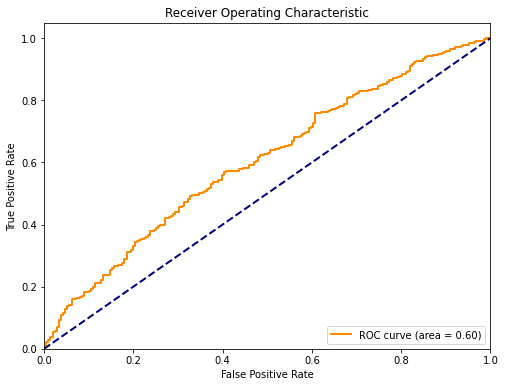

In [19]:
# Graficar la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

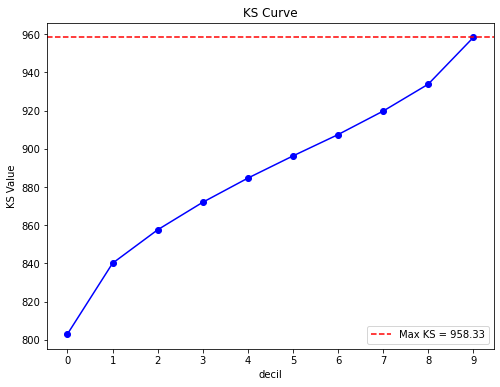

In [20]:
# Calcular las métricas de KS en cada decil
grouped = train_data.groupby('decil', as_index=False).agg({'resultado_del_riesgo': 'mean', 'score': 'mean'})
ks_by_decil = np.abs(grouped['resultado_del_riesgo'] - grouped['score'])
ks_max = max(ks_by_decil)

# Graficar la curva KS
plt.figure(figsize=(8, 6))
plt.plot(grouped['decil'], ks_by_decil, marker='o', color='b')
plt.axhline(ks_max, color='r', linestyle='--', label='Max KS = {:.2f}'.format(ks_max))
plt.xlabel('decil')
plt.ylabel('KS Value')
plt.title('KS Curve')
plt.xticks(grouped['decil'])
plt.legend()
plt.show()